# Import

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

C:\Users\niels\AppData\Local\Temp\ipykernel_33708\2554387359.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Code for Merging Files

In [ ]:
# path = "C:\\Users\\niels\\Downloads\\CPPN_runs\\CSV"
# #path = "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV"

# # Create empty dataframe
# df = pd.DataFrame([])

# # Get folders
# folders = os.listdir(path)
# folders = [folder for folder in folders if os.path.isdir(os.path.join(path, folder))]
# assert len(folders) == 10, "Should be 10 folders"
# # Get files
# for folder in folders:
#     print("Processing folder: ", folder)
#     # Get files
#     files = os.listdir(os.path.join(path, folder))
#     if os.path.isdir(os.path.join(path, folder, files[0])) and (len(files) == 1):
#         files_new = os.listdir(os.path.join(path, folder, files[0]))
#         files = [files[0] + "\\" + file for file in files_new]

#     files2concat = []
#     for file in files:
#         print("\t\tProcessing file: ", file)
#         if file.endswith(".csv"):
#             # Get data
#             df_new = pd.read_csv(os.path.join(path, folder, file))
#             # Set experiment name
#             if "CPPN" in path:
#                 encoding = file.split("_opt")[1].split("_")
#                 exp_id = (int(encoding[0]) - 1) * 2 + int(encoding[1])
#                 df_new["experiment_id"] = exp_id
#             elif "GRN" in path:
#                 check = file.split("_300_")[1].split("_")
#                 if len(check) == 2:
#                     encoding = (int(folder) - 1) * 2 + df_new["experiment_id"]
#                     df_new["experiment_id"] = encoding
#                 else:
#                     exp_id = (int(check[0]) - 1) * 2 + int(check[1])
#                     df_new["experiment_id"] = exp_id
#             files2concat.append(df_new)
#     # Add to dataframe
#     df = pd.concat(files2concat + [df], ignore_index=True)
            

In [ ]:
# with open(path + "\\Morphology.csv", "w") as f:
#     df.to_csv(f, index=False)

# Settings

In [2]:
# Paths
path_root = "D:\\AI"
paths = {"GRN": {"Random Search": "D:\\AI\\Random\\GRN", "Evolution": "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV"},
                 "CPPN": {"Random Search": "D:\\AI\\Random\\CPPN", "Evolution": "C:\\Users\\niels\\Downloads\\CPPN_runs\\CSV"}}
# Mapping for column names
mappings = {'bricks': "Number of Bricks", 'hinges': "Number of Hinges", 'modules': "Number of Modules", 
            'size': "Relative Number of Modules", 'proportion2d': "Proportion2D",
            "proportionNiels": "Proportion2D_adapted", 'single_neighbour_brick_ratio': "Single_Neighbour_Bricks", 
            'single_neighbour_ratio': "Single_Neighbours", 'double_neighbour_brick_and_active_hinge_ratio': "Double_Neighbours",
            'maxrel_llimbs': 'Maximal Length of Limbs', 'meanrel_llimbs': 'Mean Length of Limbs', 
            'stdrel_llimbs': "Standard Deviation of Limbs", 'nlimbs': "Number of Limbs",
            'joints': 'Number of Joints', 'joint_brick_ratio': 'Joint-Brick Ratio'}

# Import Data

In [3]:
# Get data
df_exp = pd.DataFrame([])
for algorithm, algodata in paths.items():
    for mode, path in algodata.items():
        for file in os.listdir(path):
            if file.endswith(".csv"):
                # Load data
                df_new = pd.read_csv(path + "\\" + file)
                df_new["Algorithm"] = algorithm
                df_new["Mode"] = mode

                # Check and select data
                if mode == "Evolution":
                    # Assert that 600 generations are present
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == (1200 + 1)

                    # Assert that all even generations have 100 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100
                    # Assert that all uneven generations have 50 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50

                elif mode == "Random Search":
                    # Only gen = 0 and offspring
                    df_new = df_new.loc[(df_new.loc[:, "generation_index"] % 2 != 0) | (df_new.loc[:, "generation_index"] == 0), :]
                    df_new["generation_index"] = df_new.loc[:, "generation_index"].values - (df_new.loc[:, "generation_index"].values // 2)
                    
                    # Assert that all experiments have 51 generations
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == 51
                    
                    
                    # Assert that all generations have 50 individuals if not generation 0
                    assert df_new.loc[df_new["generation_index"] != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50
                    # Assert that generation 0 has 100 individuals
                    assert df_new.loc[df_new["generation_index"] == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100

                # Assert that 20 reps are present
                assert len(df_new.loc[:, "experiment_id"].unique()) == 20

                # Append to existing data
                df_exp = pd.concat([df_exp, df_new], ignore_index=True)

# Rename columns
df_exp = df_exp.rename(columns=mappings)

In [4]:
# Load Random Data
path2random = "C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2"

# Get data
df_random = pd.DataFrame([])
for file in os.listdir(path2random):
    if ("morphological_measures_" in file) and (file.endswith(".csv")):
        df_random_new = pd.read_csv(path2random + "\\" + file)
        assert df_random_new["count"].sum() == 60000
        df_random = pd.concat([df_random, df_random_new], ignore_index=True)

# Rename columns
df_random = df_random.rename(columns=mappings)
df_random["Algorithm"] = "Random"

# Concatenate data
df_exp = pd.concat([df_exp, df_random], ignore_index=True)

([], [])

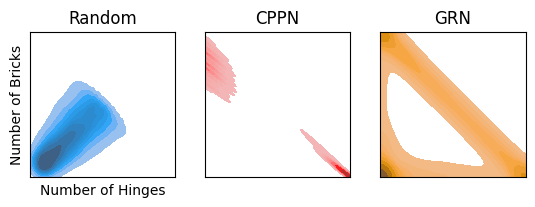

In [6]:
col1 = "Number of Hinges"
col2 = "Number of Bricks"

xlwb = df_exp[col1].min()
xupb = df_exp[col1].max()
ylwb = df_exp[col2].min()
yupb = df_exp[col2].max()

plt.subplot(1, 3, 1, aspect='equal')
df2 = df_exp.loc[df_exp["Algorithm"] == "Random"].sample(52000, weights = "count", replace = True)
df2[col1] = (df2[col1] - xlwb)/(xupb - xlwb)
df2[col2] = (df2[col2] - ylwb)/(yupb - ylwb)
sns.kdeplot(data=df2, x=col1, y=col2, fill=True,)
plt.title("Random")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2, aspect='equal')
df3 = df_exp.loc[df_exp["Algorithm"] == "CPPN"]
df3 = df3.loc[df3["Mode"] == "Random Search"]
df3[col1] = (df3[col1] - xlwb)/(xupb - xlwb)
df3[col2] = (df3[col2] - ylwb)/(yupb - ylwb)
sns.kdeplot(data=df3, x=col1, y=col2, fill=True, color="red")
plt.title("CPPN")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3, aspect='equal')
df4 = df_exp.loc[df_exp["Algorithm"] == "GRN"]
df4 = df4.loc[df4["Mode"] == "Random Search"]
df4[col1] = (df4[col1] - xlwb)/(xupb - xlwb)
df4[col2] = (df4[col2] - ylwb)/(yupb - ylwb)
sns.kdeplot(data=df4, x=col1, y=col2, fill=True, color="orange")
plt.title("GRN")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])


#plt.plot(df2["Number of Hinges"], df2["surface_area"], 'o', markeredgecolor='red', markerfacecolor='none')

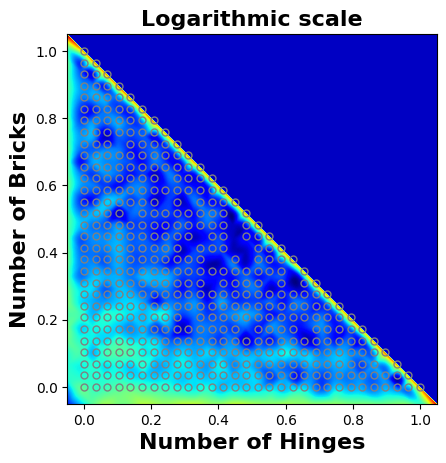

In [81]:
from scipy.interpolate import griddata

col1 = "Number of Hinges"
col2 = "Number of Bricks"
algo = "GRN"# "CPPN"#"GRN
logarithmic = True #True#False#True
unique = True #False

df_transf = (df_exp.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))

df = df_exp.loc[df_exp["Algorithm"] == algo]
if algo == "Random":
    df = df.sample(30 * 60000, weights = "count", replace = True)
else:
    df = df.loc[df["Mode"] == "Random Search"]#.sample(10000)#, weights = "count")

# Get points
points = (df.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))

if algo == "Random":
    if unique:
        points["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
    else:
        points["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts
else:
    if unique:
        points["values"] = df.drop_duplicates(["id_string"]).groupby([col1, col2]).transform("size") 
    else:
        points["values"] = df.groupby([col1, col2]).transform("size")


# Drop duplicates
points = points.drop_duplicates([col1, col2])

# Add non-existing points
dict2add = {col1: [], col2: [], "values": []}
added = []
for key in df_transf.loc[:, [col1, col2]].groupby([col1, col2]).groups.keys():
    list_key = list(key)
    if list_key not in points.loc[:, [col1, col2]].values.tolist():
        if list_key not in added:
            dict2add[col1].append(list_key[0])
            dict2add[col2].append(list_key[1])
            dict2add["values"].append(0)
            added.append(list_key)

        # dict2add[col1].append(key[0])
        # dict2add[col2].append(key[1])
        # dict2add["values"].append(0)

# Append to points
points_new = pd.concat([points, pd.DataFrame(dict2add)], ignore_index=True)
    
# Get values
values = points_new["values"].values
if logarithmic:
    values = np.log(values + 1) # Logarithmic scale
coordinates = points_new.loc[:, [col1, col2]].values

# Creat a meshgrid
mins = coordinates.min(axis = 0)
maxs = coordinates.max(axis = 0)
grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

# Interpolate
grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='cubic', fill_value = 0) # nearest, linear, cubic

# Plot
plt.imshow(grid_z0.T, extent=(mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05), origin='lower', cmap = "jet")
#plt.scatter(coordinates[:, 0], coordinates[:, 1], c = "k")
plt.xlabel(col1, fontsize = 16, fontweight = "bold")
plt.ylabel(col2, fontsize = 16, fontweight = "bold")
if logarithmic:
    plt.title("Logarithmic scale", fontsize = 16, fontweight = "bold")
else:
    plt.title("Non-logarithmic scale", fontsize = 16, fontweight = "bold")

plt.plot(points[col1], points[col2], 'o', markeredgecolor='grey', markerfacecolor='none', markersize = 5)
plt.show()

# Create Folder

In [109]:
paths4plots = [f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\Evolution", f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\Random Search",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search\\Unique",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search\\All",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\Unique\\Offspring",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\All\\Offspring",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\Unique\\Population",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\All\\Population",
               f"{path_root}\\Plots\\Niches\\Evolution", f"{path_root}\\Plots\\Niches\\Random Search",
               f"{path_root}\\Plots\\Niches\\Across_Runs\\Evolution\\GRN", f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\GRN",
               f"{path_root}\\Plots\\Niches\\Across_Runs\\Evolution\\CPPN", f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\CPPN",
               f"{path_root}\\Plots\\HeatMap\\Line\\Evolution\\CPPN", f"{path_root}\\Plots\\HeatMap\\Line\\Evolution\\GRN"

               ]
for path in paths4plots:
    if not os.path.exists(path):
        os.makedirs(path)

# Set columns to plot

In [8]:
colsn2plot = ['symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', "id_string", "experiment_id", "generation_index", "individual_index", "Mode", "Algorithm"]
columns2plot = list(df_exp.columns)
for col in colsn2plot:
    columns2plot.remove(col)

# Plot Data over Time

In [15]:
# ---- Group and apply
for mode in ["Evolution", "Random Search"]:
    medians = []
    for algo in ["CPPN", "GRN"]:
        # Select data of algorithm and mode
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]
        
        # Select even generations
        if mode == "Evolution":
            df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 == 0, :]
            df_exp2.loc[:, "generation_index"] = (df_exp2.loc[:, "generation_index"] / 2).astype(int)
        else:
            pass

        # Group and apply
        cols4group = [col for col in df_exp2.columns if col not in colsn2plot or col in ["generation_index", "experiment_id"]]	
        median_exp = df_exp2.loc[:, cols4group].groupby(["generation_index"]).median()
        std_exp = df_exp2.loc[:, cols4group].groupby(["generation_index"]).std()

        # Append
        medians.append((median_exp, std_exp, algo))

    # ---- Plot
    cols2plot = [col for col in columns2plot if col not in ["id_string", "experiment_id", "generation_index", "individual_index"]]
    for col in cols2plot:
        fig, axes = plt.subplots(1, 2)
        lwb = min([(l[0][col] - l[1][col]).min() for l in medians])
        upb = max([(l[0][col] + l[1][col]).max() for l in medians])

        for ivals, vals in enumerate(medians):
            median_exp, std_exp, algo = vals
            # ---- Mean
            plt.axes(axes[ivals])
            plt.plot(median_exp.index, median_exp.loc[:, col], label = algo, color = "k")
            # Std
            plt.fill_between(median_exp.index, median_exp.loc[:, col] - std_exp.loc[:, col], median_exp.loc[:, col] + std_exp.loc[:, col], alpha=0.2, color = "k")

            # Set limits and legend
            if mode == "Evolution":
                plt.xlim(0, 601)
            else:
                plt.xlim(0, 51)
            plt.ylim(lwb - 0.1, upb + 0.1)
            plt.legend()
            plt.grid()
        
        fig.text(0.5, 0.04, 'Generation', ha='center', va='center')

        # Set common y-axis label
        fig.text(0.06, 0.5, f'{col.title()}', ha='center', va='center', rotation='vertical')

        # Set common title
        fig.suptitle(f'{col.title()}', fontsize=16)

        plt.savefig(f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\{mode}" + f"\\{col}.png")
        plt.close()


# Violin Plots non-evolution Data

In [23]:
for type_run in ["All", "Unique"]:
    # Drop evolution data
    df_exp2 = df_exp.loc[df_exp["Mode"] != "Evolution", :]

    # ---- Violin plots
    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        # Select subset of data --> unique bodies or all? + column
        for algo in df_exp2["Algorithm"].unique():
            if type_run == "Unique":
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
            else:
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]

            # Set initialization
            df4init = deepcopy(sub_df.loc[sub_df["generation_index"] == 0, :])
            df4init.loc[:, "INIT"] = "Initialization"
            sub_df.loc[:, "INIT"] = "Random Search"
            sub_df = pd.concat([df4init, sub_df], axis=0, ignore_index=True)
            # Append
            data4violin.append(sub_df)
        
        # Concat dfs
        data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

        # Group data
        # Plot
        sns.violinplot(data4violin, x = "Algorithm", y = col, hue = "INIT", split=True, gap=0, inner="quart")
        plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        # Remove right and top spines
        sns.despine()
        plt.tight_layout()
        plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search" + f"\\{type_run}\\{col}.png")
        plt.close()

# Violin Plots over Time (Offspring Only)

In [26]:
for type_run in ["All", "Unique"]:

    # Drop non-evolution data
    df_exp2 = df_exp.loc[df_exp["Mode"] == "Evolution", :]
    # Select only uneven generations
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 != 0, :]
    df_exp2.loc[:, "generation_index"] = df_exp2.loc[:, "generation_index"].values - (df_exp2.loc[:, "generation_index"].values // 2)
    df_exp3 = deepcopy(df_exp2)
    # ---- Set generation index in steps of 0, 10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600
    # Where generation index < 10 --> 5
    df_exp3.loc[df_exp2["generation_index"] <= 600, "generation_index"] = "301-600"
    df_exp3.loc[df_exp2["generation_index"] <= 300, "generation_index"] = "101-300"
    df_exp3.loc[df_exp2["generation_index"] <= 100, "generation_index"] = "51-100"
    df_exp3.loc[df_exp2["generation_index"] <= 50, "generation_index"] = "26-50"
    df_exp3.loc[df_exp2["generation_index"] <= 25, "generation_index"] = "0-25"

    # ---- Violin plots
    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        # Select subset of data --> unique bodies or all? + column
        for algo in df_exp3["Algorithm"].unique():
            if type_run == "Unique":
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
            else:
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]
    
            # Append
            data4violin.append(sub_df)
        
        # Concat dfs
        data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

        # Group data
        # Plot

        sns.violinplot(data4violin, x = "generation_index", y = col, hue = "Algorithm", split=True, gap=0, inner="quart",
                       order = ["0-25", "26-50", "51-100", "101-300", "301-600"])
        plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        # Remove right and top spines
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\{type_run}\\Offspring" + f"\\{col}.png")
        plt.close()

C:\Users\niels\AppData\Local\Temp\ipykernel_32756\1164962625.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '301-600' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_exp3.loc[df_exp2["generation_index"] <= 600, "generation_index"] = "301-600"
C:\Users\niels\AppData\Local\Temp\ipykernel_32756\1164962625.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '301-600' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_exp3.loc[df_exp2["generation_index"] <= 600, "generation_index"] = "301-600"


#https://plotly.com/python/v3/density-plots/

In [118]:
# # Assuming 'measures_heat', 'generation', 'rank', and 'value' are your data and columns
# # Replace these with your actual data and column names
for algo in ["GRN", "CPPN"]:
    for mode in ["Evolution"]:
        # Select data
        df2 = df_exp.loc[df_exp["Mode"] == mode, :]
        df2 = df2.loc[df_exp["Algorithm"] == algo, :]

        if mode == "Evolution":
            # Select only even generations
            df2 = df2.loc[df2["generation_index"] % 2 == 0, :]
            df2.loc[:, "generation_index"] = (df2.loc[:, "generation_index"] / 2).astype(int)
        else:
            pass

        for col in columns2plot:
            # Get a column for each row according to rank within generation based on col
            df2["rank"] = df2.groupby("generation_index")[col].rank(method='first', ascending=True)
            df2pivot = df2.pivot(index = "rank", columns = "generation_index", values = col)
            # Create the heatmap plot
            heat = sns.heatmap(df2pivot, 
                            cmap='inferno', 
                            linewidths=0, 
                            linecolor='white', vmin = df_exp[col].min(), vmax = df_exp[col].max())
            
            # Set the axis labels and title
            heat.set_xlabel('Generations', fontsize=16)
            heat.set_ylabel("Robots", fontsize=16)
            heat.set_title(col.title(), fontsize=16)

            # # Set x-axis ticks
            if mode == "Evolution":
                heat.set_xticks([0, 100, 200, 300, 400, 500, 600])
                heat.set_xticklabels([0, 100, 200, 300, 400, 500, 600])
            else:
                heat.set_xticks([0, 10, 20, 30, 40, 50])
                heat.set_xticklabels([0, 10, 20, 30, 40, 50])

            # Remove y-axis ticks
            heat.set_yticks([])

            # Adjusting the plot layout
            plt.subplots_adjust(top=0.9, right=0.9)

            # Save the plot
            plt.savefig(f"{path_root}\\Plots\\HeatMap\\Line\\{mode}\\{algo}\\{col}.png")
            plt.close()

# Violin Plots over Time (Population only)

In [30]:
for type_run in ["All", "Unique"]:
    # Drop non-evolution data
    df_exp2 = df_exp.loc[df_exp["Mode"] == "Evolution", :]
    # Select only even generations
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 == 0, :]
    df_exp2.loc[:, "generation_index"] = (df_exp2.loc[:, "generation_index"].values / 2).astype(int)
    df_exp3 = deepcopy(df_exp2)

    # Select where generation_index in  [0, 25, 50, 100, 300, 600]
    df_exp3 = df_exp3.loc[df_exp3["generation_index"].isin([0, 25, 50, 100, 300, 600]), :]

    # ---- Violin plots
    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        # Select subset of data --> unique bodies or all? + column
        for algo in df_exp3["Algorithm"].unique():
            if type_run == "Unique":
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
            else:
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]
    
            # Append
            data4violin.append(sub_df)
        
        # Concat dfs
        data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

        # Group data
        # Plot

        sns.violinplot(data4violin, x = "generation_index", y = col, hue = "Algorithm", split=True, gap=0, inner="quart",
                       order = [0, 25, 50, 100, 300, 600])
        plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        # Remove right and top spines
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\{type_run}\\Population"+ f"\\{col}.png")
        plt.close()

# Densities Across Runs (Random Search)

In [47]:
for algo in df_exp["Algorithm"].unique():
      df2 = df_exp.loc[df_exp["Mode"] == "Random Search", :]
      df2 = df2.loc[df_exp["Algorithm"] == algo, :]
      for col in columns2plot:
            # Initialize the FacetGrid object
            pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
            g = sns.FacetGrid(df2, row="experiment_id", hue="experiment_id", aspect=15, height=1, palette=pal)


            # Draw the densities in a few steps
            g.map(sns.kdeplot, col,
                  bw_adjust=.5, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)
            g.map(sns.kdeplot, col, clip_on=False, color="w", lw=2, bw_adjust=.5)

            # passing color=None to refline() uses the hue mapping
            g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


            # Define and use a simple function to label the plot in axes coordinates
            def label(x, color, label):
                  ax = plt.gca()
                  ax.text(-0.2, .2, label, fontweight="bold", color=color,
                              ha="left", va="center", transform=ax.transAxes)


            g.map(label, col)

            # Set the subplots to overlap
            g.figure.subplots_adjust(hspace=0)#-.25)

            # Remove axes details that don't play well with overlap
            g.set_titles("")
            g.set(yticks=[], ylabel="")
            g.despine(bottom=True, left=True)
            plt.savefig(f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\{algo}" + f"\\{col}.png")
            plt.close()

# Niches Median

In [33]:
def get_accumulated_phenotypes(df):
    accumulated = [0]
    database = []
    for gen in df["generation_index"].unique():
        # Get unique phenotypes in generation
        unique_phenotypes = df.loc[df_exp["generation_index"] == gen, "id_string"].unique().tolist()
        # Amount not in database
        not_in_db = len(set(unique_phenotypes) - set(database))
        # Add to accumulated
        accumulated.append(accumulated[-1] + not_in_db)
        # Add to database
        database = list(set(database) | set(unique_phenotypes))
    return accumulated


# ---- For all experiments separately: Random Search & Evolution
for mode in ["Random Search", "Evolution"]:
    for algo in df_exp["Algorithm"].unique():
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]

        for exp in df_exp2["experiment_id"].unique():
            accdata.append(get_accumulated_phenotypes(df_exp2.loc[df_exp["experiment_id"] == exp])[1:])

        plt.plot(np.median(accdata, axis = 0), "-", label = algo)
        plt.fill_between(range(len(accdata[0])), np.median(accdata, axis = 0) - np.std(accdata, axis = 0), np.median(accdata, axis = 0) + np.std(accdata, axis = 0), alpha = 0.2)
    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
    plt.title(f"Unique Phenotypes over Time for {mode}", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes median.png")
    plt.close()

# Niches Total

In [34]:
# ---- For all experiments together
for mode in ["Random Search", "Evolution"]:
    for algo in df_exp["Algorithm"].unique():
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]
        # Get accumulated phenotypes
        accdata = get_accumulated_phenotypes(df_exp2)[1:]
        # Plot
        plt.plot(accdata, "-", label = algo)

    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
    plt.title(f"Unique Phenotypes over Time for {mode}", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes total.png")
    plt.close()

# Niches Sorted

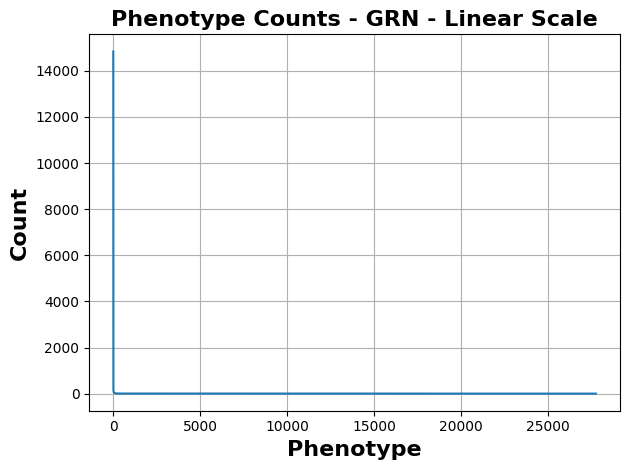

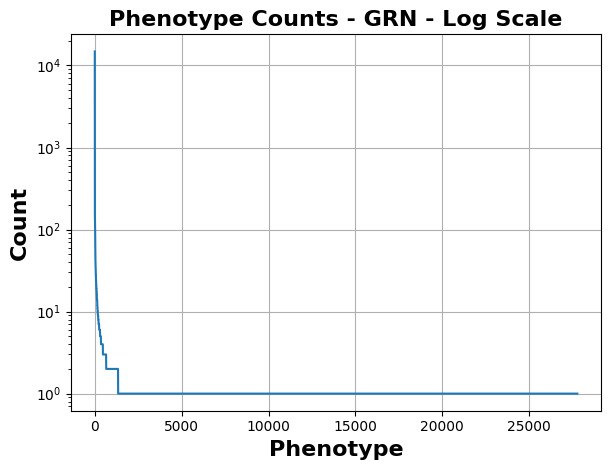

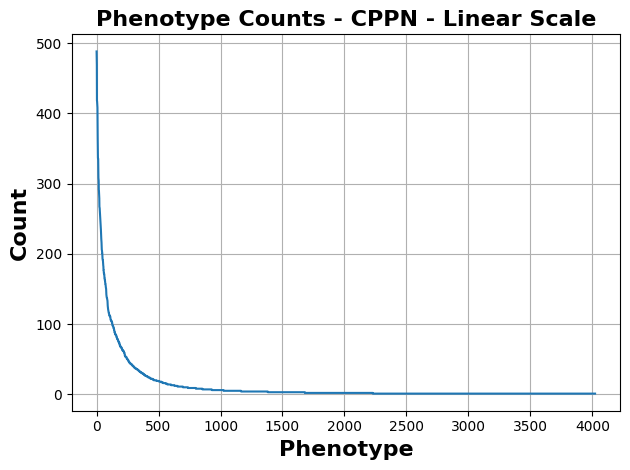

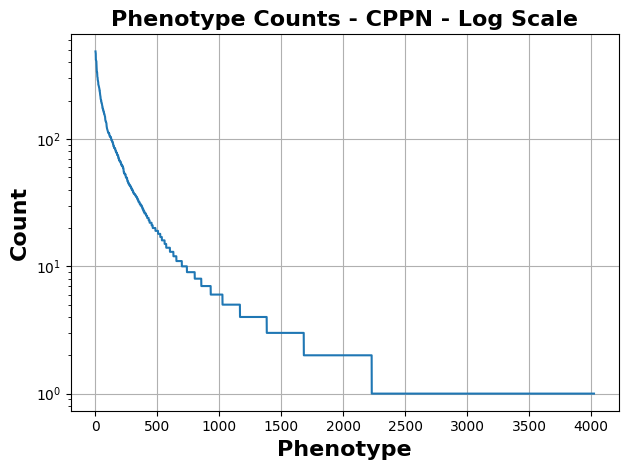

In [35]:
for algo in df_exp["Algorithm"].unique():
    df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
    df_exp2 = df_exp2.loc[df_exp2["Mode"] == "Random Search", :]
    # ---- Get plots
    for type_scale in ["linear", "log"]:
        # Get counts of id_strings, sort by count and plot
        phenotype_counts = df_exp2["id_string"].value_counts()
        phenotype_counts.sort_values(ascending = False, inplace = True)
        plt.plot(phenotype_counts.values, "-")
        plt.xlabel("Phenotype", fontsize = 16, fontweight = 'bold')
        plt.ylabel("Count", fontsize = 16, fontweight = 'bold')
        plt.title(f"Phenotype Counts - {algo} - {type_scale.title()} Scale", fontsize = 16, fontweight = 'bold')
        plt.grid()
        plt.tight_layout()
        plt.yscale(type_scale)
        plt.savefig(f"{path_root}\\Plots\\Niches\\Random Search" + f"\\phenotype counts_{type_scale}_{algo}.png")
        plt.show()
